# **Projet data mining - Système de recommandation**

### Auteurs : Bastien FREDENUCCI & Thomas MANGIN

### 1 - Téléchargement des images

In [ ]:
import traceback
import sys
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import urllib.request
import PIL.Image as Image
import numpy
import math
import matplotlib.pyplot as plot
import matplotlib.colors as mcol
import time
import json
from cluster import *
import pandas as pd
import shutil
import webcolors
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
import requests
import random
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import graphviz
import pydotplus


endpoint_url = "https://query.wikidata.org/sparql"
img_data = {}

# Requête pour récupérer les infos de l'entité donnée - Q1549591/grande ville par défault
def query(wd='Q1549591', limit=5):
    return f"""SELECT ?item ?itemLabel ?pic
                WHERE {{
                  ?item wdt:P31 wd:{wd}.
                  ?item wdt:P18 ?pic.
                  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
                }}
                LIMIT {limit}"""

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    return sparql.query().convert()
    

# Pour créer le dossier des images s'il n'existe pas
def createFolder(name='images'):
    if name not in os.listdir():
        os.mkdir(name)
    else:
        print('Dossier '+name+' déjà existant')

# Vérification si le dossier est vide pour ne pas retélécharger les images
def isEmpty(name='images'):
    if len(os.listdir(name)) == 0:
        return True
    return False

# Pour ajouter des éléments à la bdd
def addImg(wd, limit):
    results = get_results(endpoint_url, query(wd, limit))
    for result in results['results']['bindings']:
        name_img = result['item']['value'].split("/")[-1] + "-" + wd # nom donné aux images téléchargées "numéro d'image - numéro de catégorie"
        
        #img_data[name_img] = {'image': result['pic']['value']}
        
        img_data[name_img] = {}
        downloadImage(result['pic']['value'], name_img)
        

# Ajoute les images de toutes les entités spécifiées
def addAllImg(wd, limit):
    for w in wd:
        addImg(w, limit)

# Pour télécharger l'image d'un élément de la bdd
def downloadImage(url, name_img='img0'):
    full_path = 'images/' + name_img + '.jpg'
    urllib.request.urlretrieve(url, full_path)
    time.sleep(1)

# Si les images sont déjà téléchargées on initialise le tableau
def initAlreadyDownload(namefolder='images'):
    for image in os.listdir(namefolder):
        #img_data[image.split(".")[0]] = {'image': ""}
        img_data[image.split(".")[0]] = {}

# Pour télécharger toutes les images - limit par query
def downloadAllImages(wd=['Q1549591'], limit=5):
    createFolder()
    if not isEmpty():
        print('Images déjà téléchargées !')
        initAlreadyDownload()
        return False
    addAllImg(wd, limit)
    return True 

#Supprimer une image du dossier 
def removeImage(image):
    if os.path.isfile('images/'+image):
        os.remove('images/'+image)
        img_data.pop(image.split(".")[0])
    else:
        shutil.rmtree('images/'+image)

downloadAllImages(limit=125)
print(img_data)

{'Q62-Q1549591': {}, 'Q64-Q1549591': {}, 'Q65-Q1549591': {}, 'Q70-Q1549591': {}, 'Q71-Q1549591': {}, 'Q78-Q1549591': {}, 'Q85-Q1549591': {}, 'Q87-Q1549591': {}, 'Q100-Q1549591': {}, 'Q172-Q1549591': {}, 'Q174-Q1549591': {}, 'Q216-Q1549591': {}, 'Q220-Q1549591': {}, 'Q239-Q1549591': {}, 'Q240-Q1549591': {}, 'Q268-Q1549591': {}, 'Q270-Q1549591': {}, 'Q279-Q1549591': {}, 'Q288-Q1549591': {}, 'Q334-Q1549591': {}, 'Q350-Q1549591': {}, 'Q365-Q1549591': {}, 'Q384-Q1549591': {}, 'Q385-Q1549591': {}, 'Q393-Q1549591': {}, 'Q406-Q1549591': {}, 'Q437-Q1549591': {}, 'Q456-Q1549591': {}, 'Q490-Q1549591': {}, 'Q495-Q1549591': {}, 'Q546-Q1549591': {}, 'Q580-Q1549591': {}, 'Q582-Q1549591': {}, 'Q585-Q1549591': {}, 'Q586-Q1549591': {}, 'Q588-Q1549591': {}, 'Q597-Q1549591': {}, 'Q598-Q1549591': {}, 'Q612-Q1549591': {}, 'Q617-Q1549591': {}, 'Q628-Q1549591': {}, 'Q641-Q1549591': {}, 'Q647-Q1549591': {}, 'Q648-Q1549591': {}, 'Q649-Q1549591': {}, 'Q656-Q1549591': {}, 'Q690-Q1549591': {}, 'Q715-Q1549591': {},

### 2 - Gestion des métadonnées

In [24]:
#Obtenir les metas d'une image
def getMetaImg(name, imgfile):
    #clés Exif
    DATE_KEY = 36867
    MODEL_KEY = 272
    
    img_data[name].update({
        'size': getSizeImg(imgfile.size),
        'orientation': getOrientationImg(imgfile.size),
        'format': imgfile.format,
    })
    
    getColorsImg(name, imgfile)
    
    exif_data = imgfile._getexif()
    if exif_data is not None:
        if DATE_KEY in exif_data:
            img_data[name]['date'] = exif_data[DATE_KEY]
        if MODEL_KEY in exif_data:
            img_data[name]['model'] = exif_data[MODEL_KEY]

def getOrientationImg(size): #(largeur,hauteur)
    width,height = size
    return "landscape" if width > height else "portrait" if height > width else "squared"
    
def getSizeImg(size): #(largeur,hauteur)
    width,height = size
    return "large" if width*height>1920*1080 else "small" if width*height<640*480 else "medium"

def getColorsImg(name, imgfile, cluster_nbr=2, n_init=1):
    
    img_data[name]['colors'] = []
    
    # Redimensionner l'image pour accélérer le traitement
    imgfile = imgfile.resize((int(imgfile.size[0]/2), int(imgfile.size[1]/2)))

    # Convertir l'image en un tableau numpy
    img_array = numpy.array(imgfile)
    
    img_vector = img_array.reshape(-1, 3)

    clusters = MiniBatchKMeans(n_clusters=cluster_nbr, n_init=n_init, random_state=69).fit(img_vector) #Random state pour garder la meme seed ppour toutes les images

    for i, center in enumerate(clusters.cluster_centers_):
        rgb = tuple(map(int, center))
        

    img_data[name]['colors'].append(rgb)
            

def openImgGetMeta(name): #name = 'img.jpg'
    # print(f"Processing: {name}")  # pour identifier l'image si erreur
    with Image.open("images/"+name) as imgfile:
        #print(imgfile.size, imgfile.format)
        name = name.split(".")[0]
        getMetaImg(name, imgfile)

    imgfile.close()
        
#Obtenir les metas de toutes nos images    
def openGetMetaAllImg(namefolder='images'):
    for image in os.listdir(namefolder):
        openImgGetMeta(image)

openGetMetaAllImg()

C:\Users\Thomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (99998272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


### Creation / ouverture du fichier JSON

In [25]:
#Enregistre les metadonnées des images dans un JSON
def exportToJSON(data,name='img_data.json'):
    with open(name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print("done")

def openJSON(file="img_data.json"):
    # Ouvrir le fichier JSON en mode lecture (fermé automatiquement)
    with open(file, 'r') as f:
        data = json.load(f)
    return data

#exportToJSON(data=img_data)

### Ajout de catégories supplémentaires

In [26]:
# Requête API à Wikidata pour récupérer les catégories de l'image
def wikidataAPI(_id):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={_id}&props=labels|claims&languages=en&format=json"
    response = requests.get(url)
    return json.loads(response.text)


def findTagsImg(_id): #"Q7704028-Q144 "Q7704028" est l'identifiant de l'image et "Q144" est l'identifiant de la catégorie"
    
    image_id, cat_id = _id.split("-")
    
    # Requête API à Wikidata pour récupérer les catégories de l'image
    
    #img_data = wikidataAPI(image_id)
    cat_data = wikidataAPI(cat_id)
    
    # Extraire le libellé de la catégorie
    main_tag = cat_data.get('entities', {}).get(cat_id, {}).get('labels', {}).get('en', {}).get('value', '')
        
    categories = [main_tag]
    
    return categories


def formatCategory(categories):
    categories_ = []
    
    removeCar = ['(', ')']
    splitCar = [',', ' ']
    
    for category in categories:
        if isinstance(category, str):
            for car in removeCar:
                category = category.replace(car, '')
            for car in splitCar:
                parts = category.split(car)
                if len(parts) > 1:
                    categories_.extend(parts[1:])
                    category = parts[0]
            categories_.append(category.lower())
    
    return categories_


def addTagsJSON(image_id = "Q7704028", categories=[]):
    data = openJSON(file="img_data.json")
    data[image_id]['tags'] = categories


def addAllTagsJSON():
    for _id in data:
        data[_id]['tags'] = findTagsImg(_id)
    return data

#data = openJSON(file="img_data.json")
data = img_data
data = addAllTagsJSON()
exportToJSON(data)

done


### Analyse des données

In [27]:
# Class utilisateur
class User:
    def __init__(self, favorite_pictures=[]):
        self._favorite_colors = []
        self._favorite_orientations = []
        self._favorite_sizes = []
        self._favorite_tags = []
        self._favorite_pictures = favorite_pictures
        
        if favorite_pictures != None:
            self.init_user()

    def get_favorite_pictures(self):
        return self._favorite_pictures

    def __str__(self):
        return f"User with favorite color {self._favorite_colors}, orientation {self._favorite_orientations}, size {self._favorite_sizes}, tags {self._favorite_tags} and favorite pictures {self._favorite_pictures}"
    
    
    def init_user(self):
        for img in self._favorite_pictures:
            img = img.split(".")[0]
            self._favorite_colors += [data[img]["colors"]]
            self._favorite_orientations.append(data[img]["orientation"])
            self._favorite_tags += [data[img]["tags"]]
            self._favorite_sizes.append(data[img]["size"])
            
    def get_favorite_tags(self):
        return self._favorite_tags
    
    def get_favorite_orientations(self):
        return self._favorite_orientations
    
    def get_favorite_colors(self):
        return self._favorite_colors
    
    def get_favorite_sizes(self):
        return self._favorite_sizes
    
    def add_favorite_picture(self, picture):
        self._favorite_pictures.append(picture)

number_users = 10
users = []

for i in range(number_users):
    
    number_pictures_liked = random.randint(8, 12)
    
    user = User(favorite_pictures=random.sample(os.listdir("images"), k=number_pictures_liked))
    users.append(user)



user = users[0]

print(user._favorite_pictures)

dataFrame = pd.read_json('img_data.json').T
dataFrame

['Q268-Q1549591.jpg', 'Q1850-Q1549591.jpg', 'Q393-Q1549591.jpg', 'Q1055-Q1549591.jpg', 'Q975-Q1549591.jpg', 'Q915-Q1549591.jpg', 'Q1794-Q1549591.jpg', 'Q597-Q1549591.jpg', 'Q490-Q1549591.jpg', 'Q270-Q1549591.jpg']


,size,orientation,format,colors,date,model,tags
Q62-Q1549591,large,landscape,JPEG,"[[127, 179, 208]]",2019:03:31 12:18:14,E-M10,[big city]
Q64-Q1549591,large,landscape,JPEG,"[[50, 63, 41]]",2012:05:20 15:18:47,Canon EOS 5D Mark II,[big city]
Q65-Q1549591,large,landscape,JPEG,"[[200, 158, 163]]",2019:02:06 17:32:26,Canon EOS 80D,[big city]
Q70-Q1549591,medium,landscape,PNG,"[[27, 60, 51]]",NaN,NaN,[big city]
Q71-Q1549591,medium,landscape,JPEG,"[[130, 145, 167]]",2008:08:24 15:29:16,DSC-R1,[big city]
...,...,...,...,...,...,...,...
Q1800-Q1549591,small,landscape,JPEG,"[[95, 79, 55]]",NaN,NaN,[big city]
Q1829-Q1549591,large,landscape,JPEG,"[[103, 97, 75]]",2007:07:15 15:03:06,Canon EOS 30D,[big city]
Q1842-Q1549591,large,landscape,JPEG,"[[194, 187, 184]]",2018:10:20 15:26:37,NIKON D3300,[big city]
Q1850-Q1549591,medium,landscape,JPEG,"[[75, 79, 77]]",2005:09:27 12:43:33,NIKON D100,[big city]


### Préparation des données

On définit des valeurs numériques correspondantes à chaques paramètres

In [28]:
def prepData(dataFrame):
    dataFrame['colors'] = dataFrame['colors'].apply(lambda x: [[0,0,0], [0,0,0]] if len(x) == 0 else x)

    dataFrame = dataFrame.drop(columns=['date','model'])


    le1 = LabelEncoder()
    dataFrame['size'] = le1.fit_transform(dataFrame['size'])

    le2 = LabelEncoder()
    dataFrame['orientation'] = le2.fit_transform(dataFrame['orientation'])

    le3 = LabelEncoder()
    dataFrame['format'] = le3.fit_transform(dataFrame['format'])

    le4 = LabelEncoder()
    dataFrame['couleur'] = le4.fit_transform([mcol.to_hex([couleur[0][0]/255,couleur[0][1]/255,couleur[0][2]/255]) if len(couleur[0]) > 0 else 0 for couleur in dataFrame["colors"]])

    le5 = LabelEncoder()
    dataFrame['tag'] = le5.fit_transform([tag[0] for tag in dataFrame['tags']])

    dataFrame = dataFrame.drop(columns=['tags', 'colors'])
    return dataFrame



dataFrame = prepData(dataFrame)
dataFrame

,size,orientation,format,couleur,tag
Q62-Q1549591,0,0,0,79,0
Q64-Q1549591,0,0,0,11,0
Q65-Q1549591,0,0,0,117,0
Q70-Q1549591,1,0,2,4,0
Q71-Q1549591,1,0,0,80,0
...,...,...,...,...,...
Q1800-Q1549591,2,0,0,71,0
Q1829-Q1549591,0,0,0,75,0
Q1842-Q1549591,0,0,0,113,0
Q1850-Q1549591,1,0,0,48,0


In [29]:

resultframe = pd.DataFrame(numpy.full(len(dataFrame),"not liked"), columns=['liked'], index= dataFrame['size'].index)
for img in user._favorite_pictures:
    resultframe.at[img.split('.')[0], 'liked'] = 'liked'

le7 = LabelEncoder()

resultframe['liked'] = le7.fit_transform(resultframe['liked'])

resultframe

,liked
Q62-Q1549591,1
Q64-Q1549591,1
Q65-Q1549591,1
Q70-Q1549591,1
Q71-Q1549591,1
...,...
Q1800-Q1549591,1
Q1829-Q1549591,1
Q1842-Q1549591,1
Q1850-Q1549591,0


#### Arbre de décision

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.91      0.91      0.91        23

    accuracy                           0.84        25
   macro avg       0.46      0.46      0.46        25
weighted avg       0.84      0.84      0.84        25



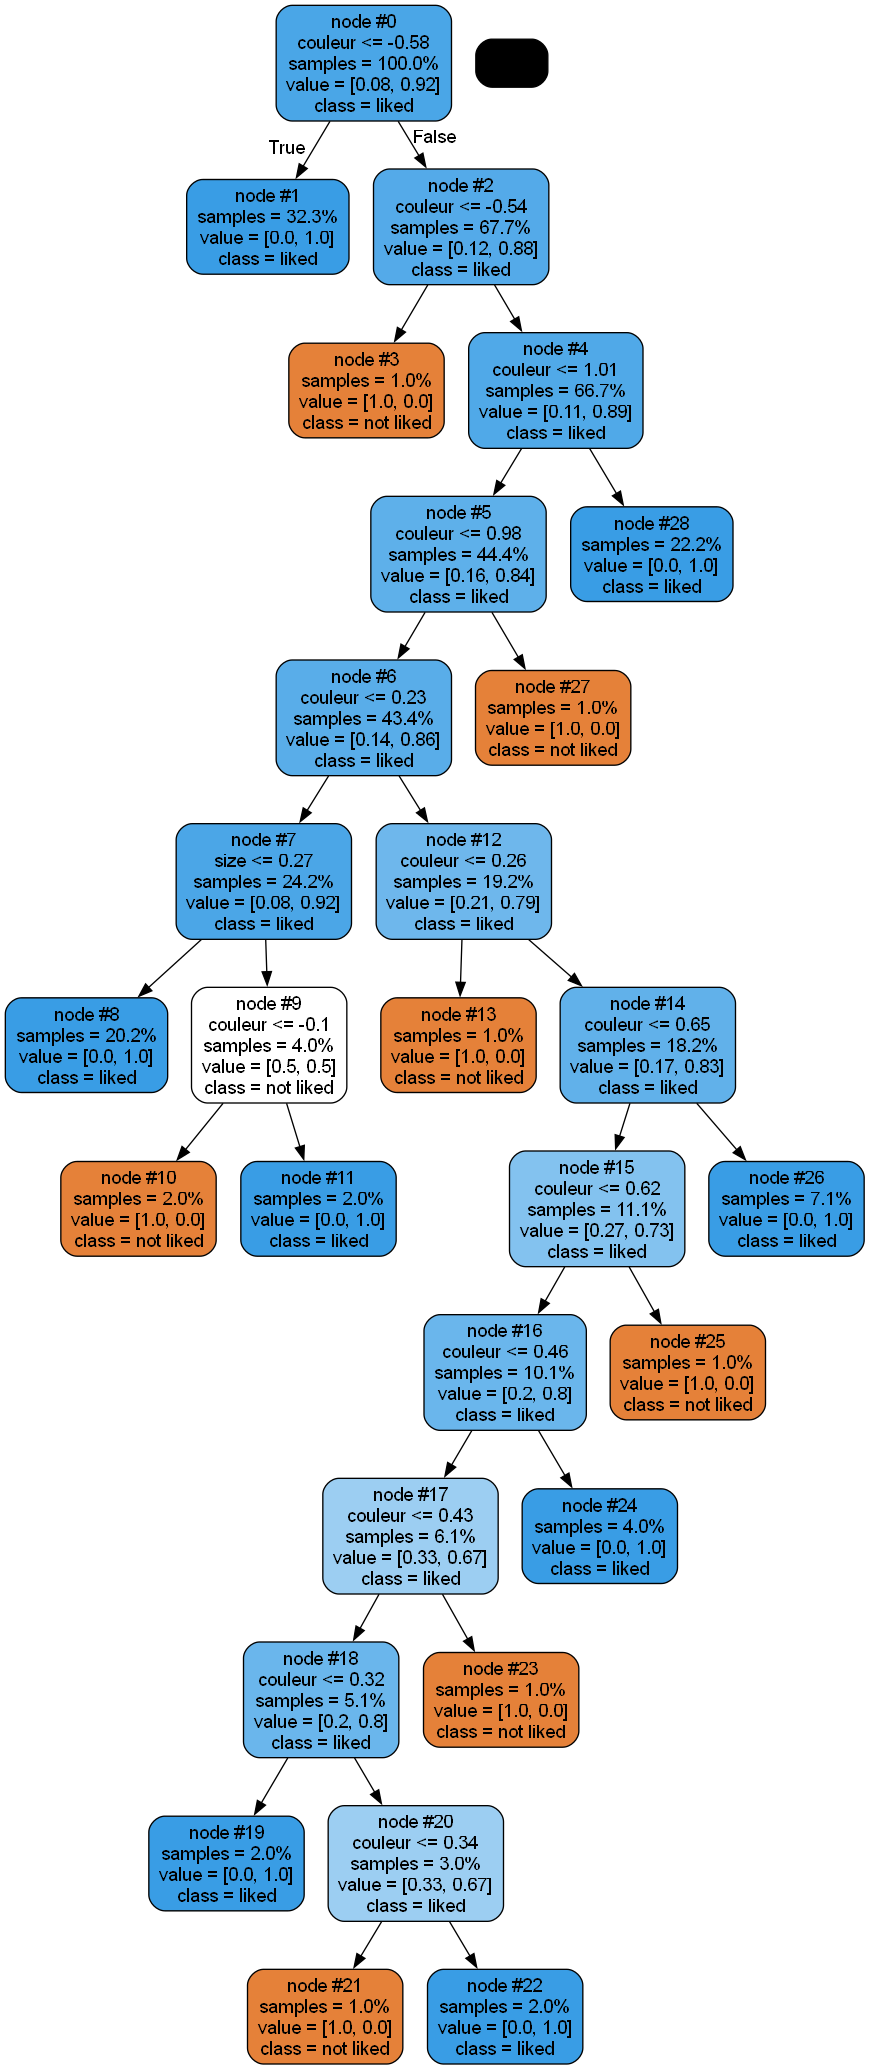

Importance des variables :
1. couleur (0.886676)
2. size (0.113324)
3. tag (0.000000)
4. format (0.000000)
5. orientation (0.000000)
[1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [30]:
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

# Séparation en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(dataFrame, resultframe, test_size=0.2, random_state=69)

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Entraînement du modèle
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Évaluation du modèle
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# Affichage de l'arbre de décision
dot_data = tree.export_graphviz(
    dtc, 
    out_file=None,
    filled=True, 
    rounded=True,
    class_names=le7.inverse_transform(resultframe.liked.unique()),
    feature_names=dataFrame.columns,
    proportion=True,
    impurity=False,
    precision=2,
    node_ids=True
) 

graph = graphviz.Source(dot_data) 
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

import io

img = Image.open(io.BytesIO(pydot_graph.create_png()))
display(img)

# Affichage de l'importance des variables
importances = dtc.feature_importances_
indices = numpy.argsort(importances)[::-1]
print("Importance des variables :")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, dataFrame.columns[indices[f]], importances[indices[f]]))
    
    
print(y_pred)

#### Random forest classifier

In [31]:
# Entraînement du modèle
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=69)
rfc.fit(X_train, y_train.to_numpy().ravel())

# Évaluation du modèle
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# Affichage de l'importance des variables
importances = rfc.feature_importances_
indices = numpy.argsort(importances)[::-1]
print("Importance des variables :")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, dataFrame.columns[indices[f]], importances[indices[f]]))
    
    
print(y_pred)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.92      0.96      0.94        23

    accuracy                           0.88        25
   macro avg       0.46      0.48      0.47        25
weighted avg       0.84      0.88      0.86        25

Importance des variables :
1. couleur (0.889923)
2. size (0.056332)
3. format (0.042007)
4. orientation (0.011737)
5. tag (0.000000)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]


### Visualisation des données

#### Nombre d'images par années

{'2019:': 8, '2012:': 5, '': 42, '2008:': 4, '2006:': 4, '2015:': 4, '2023:': 3, '2005:': 3, '2014:': 5, '2016:': 8, '2017:': 6, '2018:': 6, '2013:': 9, '2007:': 3, '2021:': 1, '2004:': 1, '2011:': 3, '2022:': 3, '2009:': 2, '2001:': 1, '2020:': 1, '2010:': 1, '30/04': 1}


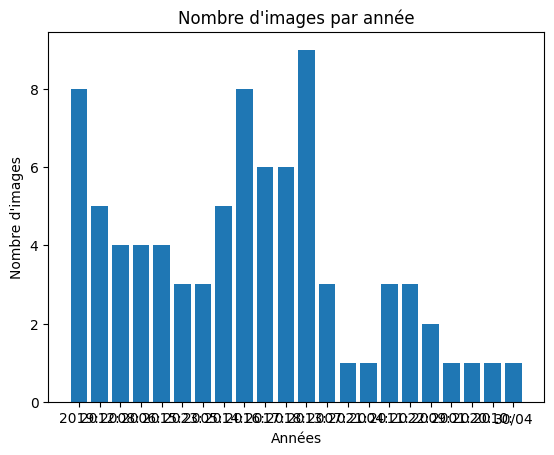

In [32]:
nb_images_year = {}

for image in data:
    date = data[image].get('date', '')[0:5] #Recuperation de la date de l'image
    nb_images_year[date] = nb_images_year.get(date,0) +1
    
print(nb_images_year)

#Pour retirer les images sans date
nb_images_year.pop('')

noms = list(nb_images_year.keys())
valeurs = list(nb_images_year.values())

plot.bar(noms, valeurs)
plot.title("Nombre d'images par année")
plot.xlabel("Années")
plot.ylabel("Nombre d'images")
plot.show()

#### Nombre d'images pour différentes caractéristiques

{'large': 82, 'medium': 39, 'small': 3}
{'landscape': 110, 'portrait': 14}
{'E-M10           ': 1, 'Canon EOS 5D Mark II': 6, 'Canon EOS 80D': 1, '': 44, 'DSC-R1': 1, 'NIKON D50': 2, 'NIKON D3100': 3, 'DMC-LC43': 1, 'NIKON D3500': 1, 'Canon EOS DIGITAL REBEL': 1, 'DMC-FZ5': 1, 'NIKON D5300': 1, 'FC350': 1, 'Canon EOS 7D': 1, 'PRA-LX1': 1, 'Canon EOS 500D': 1, 'Canon EOS 5DS': 1, 'X-T30': 1, 'Canon EOS 50D': 2, 'SP500UZ': 1, 'Canon EOS 450D': 1, 'NIKON D7000': 1, 'NIKON D600': 2, 'NIKON D750': 2, 'Canon EOS 400D DIGITAL': 1, 'NIKON D5100': 3, 'H3113': 1, 'NIKON D800E': 1, 'NIKON D610': 1, 'Canon EOS 5D Mark III': 1, 'DSC-RX100': 1, 'NIKON D3S': 1, 'Canon EOS 6D': 1, '3.1M DigitalCAM': 1, 'OpticFilm 120': 1, 'NIKON D40': 1, 'GT-S5830': 1, 'Canon PowerShot G7': 1, 'X-H1': 1, 'DiMAGE Z3': 1, 'FC2103': 1, 'ILCE-7RM3': 1, 'Canon EOS REBEL T4i': 1, 'DMC-TZ3': 1, 'Canon EOS 350D DIGITAL': 1, 'Canon PowerShot S10': 1, 'Canon EOS 800D': 1, 'FinePix S5500  ': 1, 'X-E1': 1, 'NIKON D90': 1, 'Canon 

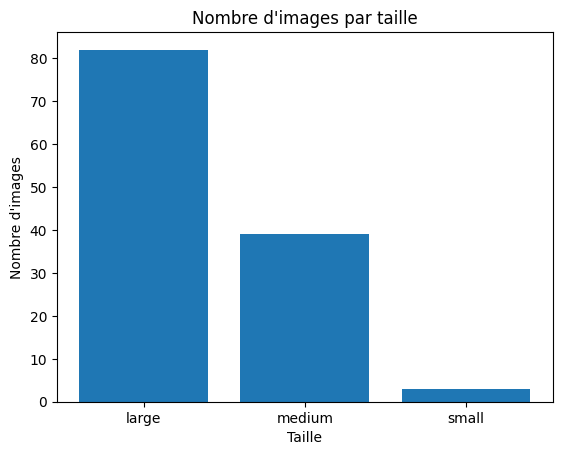

C:\Users\Thomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


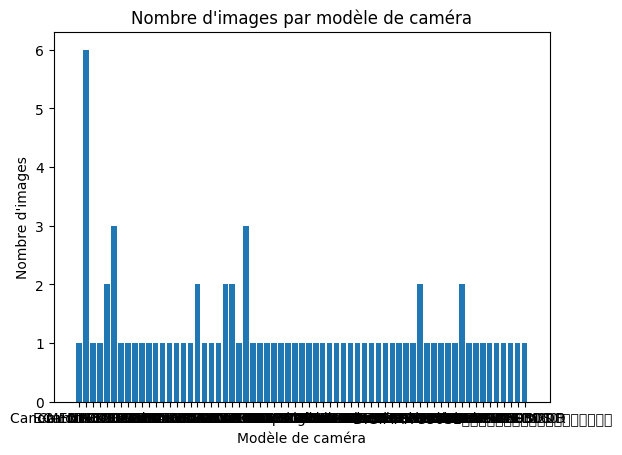

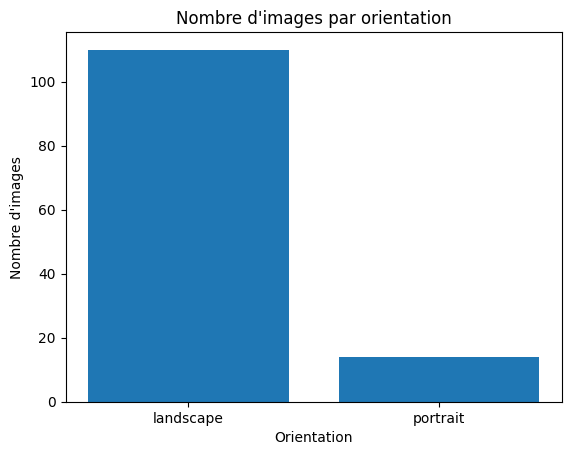

In [33]:
nb_images_size = {}
nb_images_orientation = {}
nb_images_camera = {}


for image in data :
   size = data[image].get('size','')
   nb_images_size[size] = nb_images_size.get(size,0) +1
  
   orientation = data[image].get('orientation','')
   nb_images_orientation[orientation] = nb_images_orientation.get(orientation,0) +1
  
   camera = data[image].get('model','')
   nb_images_camera[camera] = nb_images_camera.get(camera,0) +1
  
print(nb_images_size)
print(nb_images_orientation)
print(nb_images_camera)

nb_images_camera.pop('')

entity1 = list(nb_images_size.keys())
val1 = list(nb_images_size.values())
plot.bar(entity1, val1)
plot.title("Nombre d'images par taille")
plot.xlabel("Taille")
plot.ylabel("Nombre d'images")
plot.show()

entity3 = list(nb_images_camera.keys())
val3 = list(nb_images_camera.values())
plot.bar(entity3, val3)
plot.title("Nombre d'images par modèle de caméra")
plot.xlabel("Modèle de caméra")
plot.ylabel("Nombre d'images")
plot.show()

entity2 = list(nb_images_orientation.keys())
val2 = list(nb_images_orientation.values())
plot.bar(entity2, val2)
plot.title("Nombre d'images par orientation")
plot.xlabel("Orientation")
plot.ylabel("Nombre d'images")
plot.show()



#### Affichage des principales couleurs

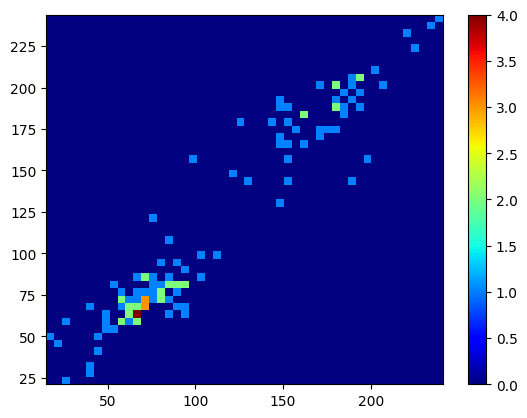

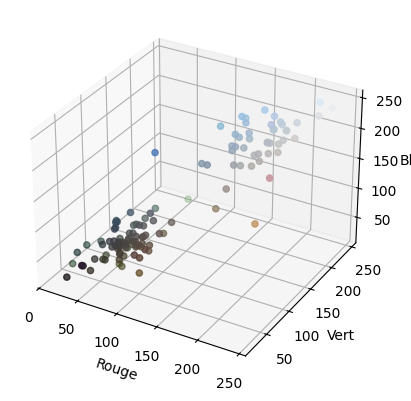

In [34]:
### 2D

# Initialiser un tableau vide pour stocker toutes les couleurs
all_colors = []

# Parcourir toutes les images et ajouter leurs couleurs à la liste de toutes les couleurs
for image in data:
    colors = data[image]['colors']
    all_colors += colors

# Convertir la liste de couleurs en un tableau NumPy
all_colors = numpy.array(all_colors)

# Créer l'histogramme en utilisant Matplotlib
plot.hist2d(all_colors[:, 0], all_colors[:, 1], bins=50, cmap=plot.cm.jet)
plot.colorbar()

# Afficher l'histogramme
plot.show()

### 3D

# Initialiser les listes de coordonnées x, y et z
x = []
y = []
z = []

colors = []

# Parcourir toutes les images dans le fichier JSON
for image in data:
    # Parcourir toutes les couleurs pour chaque image
    for color in data[image]['colors']:
        # Ajouter les valeurs RGB aux listes x, y et z
        r, g, b = color
        x.append(r)
        y.append(g)
        z.append(b)
        colors.append(mcol.to_hex([r/255,g/255,b/255]))
# Créer une figure en 3D
fig = plot.figure()
ax = fig.add_subplot(111, projection='3d')

# Ajouter les points au graphique en 3D
ax.scatter(x, y, z, c=colors, marker='o')

# Ajouter des labels aux axes
ax.set_xlabel('Rouge')
ax.set_ylabel('Vert')
ax.set_zlabel('Bleu')

# Afficher le graphique
plot.show()

### Système de recommandation

In [35]:
# Prédiction sur une image aléatoire :
dataFrame = pd.read_json('img_data.json').T

ligne_aleatoire = dataFrame.sample()

ligne_aleatoire

,size,orientation,format,colors,date,model,tags
Q1295-Q1549591,large,landscape,JPEG,"[[92, 65, 52]]",2011:10:28 16:09:57,Canon EOS 350D DIGITAL,[big city]


In [36]:
ligne_aleatoire = prepData(ligne_aleatoire)

new_data = scaler.transform(ligne_aleatoire) # normalisation des données
y_pred = rfc.predict(new_data) # prédiction

# Affichage des prédictions
print(y_pred) #1 = Oui, 0 = non

[1]


In [37]:
# Prédiction sur toutes les données : 

dataFrame = pd.read_json('img_data.json').T

dataFrame = prepData(dataFrame)

new_data = scaler.transform(dataFrame) # normalisation des données
y_pred = rfc.predict(new_data) # prédiction

# Affichage des prédictions
print(y_pred) #1 = Oui, 0 = non

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1]


In [38]:
resultats = []

for i,resultat in enumerate(y_pred):
    if resultat == 1:
        resultats.append(dataFrame.index[i])

print(f"Les images suivantes sont susceptibles de plaire à l'utilisateur : \n{resultats}")

Les images suivantes sont susceptibles de plaire à l'utilisateur : 
['Q62-Q1549591', 'Q64-Q1549591', 'Q65-Q1549591', 'Q70-Q1549591', 'Q71-Q1549591', 'Q78-Q1549591', 'Q85-Q1549591', 'Q87-Q1549591', 'Q100-Q1549591', 'Q172-Q1549591', 'Q174-Q1549591', 'Q216-Q1549591', 'Q220-Q1549591', 'Q239-Q1549591', 'Q240-Q1549591', 'Q268-Q1549591', 'Q270-Q1549591', 'Q279-Q1549591', 'Q288-Q1549591', 'Q334-Q1549591', 'Q350-Q1549591', 'Q365-Q1549591', 'Q384-Q1549591', 'Q385-Q1549591', 'Q393-Q1549591', 'Q406-Q1549591', 'Q437-Q1549591', 'Q456-Q1549591', 'Q490-Q1549591', 'Q495-Q1549591', 'Q546-Q1549591', 'Q580-Q1549591', 'Q582-Q1549591', 'Q585-Q1549591', 'Q586-Q1549591', 'Q588-Q1549591', 'Q597-Q1549591', 'Q598-Q1549591', 'Q612-Q1549591', 'Q617-Q1549591', 'Q628-Q1549591', 'Q641-Q1549591', 'Q647-Q1549591', 'Q648-Q1549591', 'Q649-Q1549591', 'Q656-Q1549591', 'Q690-Q1549591', 'Q715-Q1549591', 'Q727-Q1549591', 'Q749-Q1549591', 'Q761-Q1549591', 'Q793-Q1549591', 'Q807-Q1549591', 'Q883-Q1549591', 'Q887-Q1549591', 'Q89